In [1]:
%pylab inline
rcParams['image.aspect'] = 'auto'
rcParams['figure.figsize'] = (10,8)

Populating the interactive namespace from numpy and matplotlib


# Loading data

In [2]:
from iuvs import io
%autocall 1

Automatic calling is: Smart


In [3]:
files = !ls ~/data/iuvs/level1b/*.gz
files

['/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode080-fuv_20140521T120028_v00_r00.fits.gz',
 '/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_cruisecal2-mode080-muv_20140521T120028_v00_r00.fits.gz',
 '/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_periapse-orbit00108-mode0001-fuv_20141018T113414_v01_r01.fits.gz',
 '/Users/maye/data/iuvs/level1b/mvn_iuv_l1b_periapse-orbit00108-mode0001-muv_20141018T113414_v01_r01.fits.gz']

In [4]:
l1b = io.L1BReader(files[1])

The `darks_interpolated` data-cube consists of the interpolated darks that have been subtracted from the raw image cube for this observation. They are originally named `background_dark` but I find that confusing with `detector_dark`.

In [5]:
l1b.darks_interpolated.shape

(46, 62, 341)

defining dark1 and 2. (Could be 2 and 3rd of a set of 3, with 2 before light images, or just 1 and 1.

In [6]:
dark0 = l1b.detector_dark[0]
dark1 = l1b.detector_dark[1]
dark2 = l1b.detector_dark[2]

# some dark stats

In [7]:
io.image_stats(dark0)

count    21142.000000
mean       428.506102
std        317.761197
min         76.000000
25%        254.000000
50%        350.000000
75%        501.500000
max       4408.000000
dtype: float64

In [8]:
io.image_stats(dark1)

count    21142.000000
mean       421.120424
std        312.804889
min         66.000000
25%        248.000000
50%        344.000000
75%        492.000000
max       4346.000000
dtype: float64

In [9]:
io.image_stats(dark2)

count    21142.000000
mean       656.945228
std        397.894632
min        124.000000
25%        420.000000
50%        560.000000
75%        772.000000
max       4732.000000
dtype: float64

In [10]:
def compare_darks(dark1, dark2):
    fig, ax = subplots(nrows=2)
    ax[0].imshow(dark1, vmin=0, vmax=1000,cmap='gray')
    ax[1].imshow(dark2, vmin=0, vmax=1000,cmap='gray')

In [11]:
l1b.detector_raw.shape

(46, 62, 341)

In [12]:
l1b.detector_dark.shape

(3, 62, 341)

In [13]:
rcParams['figure.figsize']

[10.0, 8.0]

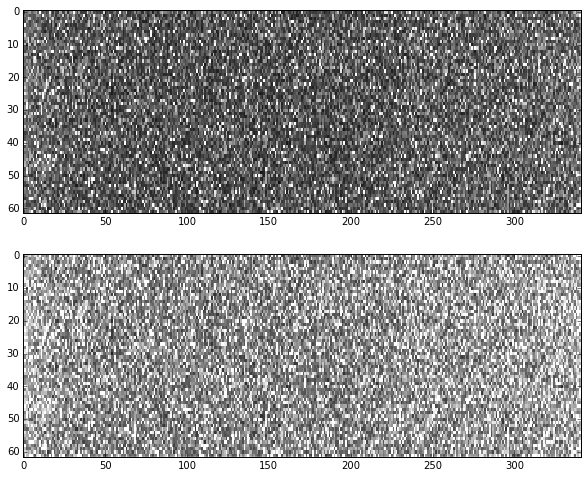

In [14]:
compare_darks(dark1,dark2)

# dark histograms

first showing how the 3 darks are differing in their histogram:

In [ ]:
# _, axes = subplots(2)
for i, dark in enumerate([dark0, dark1, dark2]):
    hist(dark.ravel(), 100, range=(0,5000), log=True, label='dark'+str(i),alpha=0.5)
legend()

As one can see, the first 2 darks are very similar and the last dark taken 47 minutes later has a quite different histogram. Let's see how it looks if we just push up the histogram by the mean value difference of the 2 darks:

In [ ]:
delta_mean = abs(dark1.mean() - dark2.mean())
delta_mean

In [ ]:
def myhist(data, **kwargs):
    hist(data.ravel(), 100, range=(0,5000), log=True, alpha=0.5, **kwargs)

In [ ]:
fig, axes = subplots(nrows=2)
axes = axes.ravel()
for i, dark in enumerate([dark1, dark2]):
    axes[0].hist(dark.ravel(), 100, range=(0, 5000), log=True, label='dark'+str(i+1),
                 alpha=0.5)
axes[0].legend()
axes[0].set_title('Original dark1 and dark2 histograms')
for txt,dark in zip(['dark1+delta_mean','dark2'],[dark1+delta_mean,dark2]):
    axes[1].hist(dark.ravel(), 100, range=(0, 5000), log=True, label=txt, alpha=0.5)
axes[1].legend()
axes[1].set_title('Shifted dark1 histogram by the difference of their means')

The remaining difference in the shape of the histogram make me believe that a pure additive fix can never make one dark to be subtractable by the other one.

# line profiles

The failure of additive correction can also be shown for a line profile at an arbitrary spatial pixel. 
Below I plot a line profile for row `spatial` for the 2nd dark (dark1) and the last dark (dark2).
In preparation for the future focus on only the sides of the spectral I zoom into the plot both on the left and right 25 pixels of the total range in the data.
Adding a range of values trying to match the profile of dark1 to dark2 shows that either the minima or the maxima can be fit but never both at the same time.

Possibly reason though: Could it be eval pixels that prevent this from working? Or are there by far not enough of them?

In [ ]:
spatial = 30
fig, axes = subplots(ncols=2)
axes = axes.ravel()
def do_plot(ax):
    ax.plot(dark2[spatial], '--', label='dark2')
    ax.plot(dark1[spatial], '--', label='dark1')
    for delta in range(180, 230, 10):
        ax.plot(dark1[spatial]+delta, label=delta)
    ax.legend(loc='best',ncol=2)
    ax.set_ylim(0,1000)
do_plot(axes[0])
axes[0].set_xlim(0,25)
axes[0].set_title('Left 25 spectral bins')
do_plot(axes[1])
length = dark2.shape[1]
axes[1].set_xlim(length-25,length)
axes[1].set_title('Right 25 spectral bins')

# What do interpolated darks do

I'm having doubts about the premise that a dark should be subtractable from a dark in all cases.
I'm thinking that if the main premise is that our data should tell us what to do, then the corollar is that some kind of interpolated dark between 2 darks is the truth that needs to be subtracted from the raw image. The question is what changed over time. As temperature is one of the main things that we know has changed from dark1 to dark2, I find it paramount to take temperature into account as a parameter for the interpolation.

But let's see what the currently interpolated darks do.

In [ ]:
# missing code for interpolation check.

In [ ]:
raw0 = l1b.detector_raw[0]
spatial = l1b.detector_raw.shape[1]//2
plot(raw0[spatial] - dark1[spatial], 'g', 
     label='first light minus 2nd dark')
plot(raw0[spatial] - dark2[spatial], 'b', 
     label='first light minus last dark')
title("Show the importance of taking the right dark")
legend()

In [ ]:
imshow(l1b.detector_raw[-1])
title("Last light image in cube")

In [ ]:
fig, axes = subplots(nrows=3)
raw = l1b.detector_raw
axes[0].imshow(raw[0])
axes[1].imshow(raw[1])
axes[2].imshow(raw[2])
fig.suptitle("First 3 lights in cube")

# How do the darks ratio with each other?
## Dark 0 / Dark 1

In [ ]:
spatial = 20
data = dark0[spatial]/dark1[spatial]
plot(data, label=spatial)
legend(loc='best')
title("one row, first dark / second dark. Mean:{:.2f}".format(data.mean()))
grid()

## Dark 0 / Dark 2 (last one)

In [ ]:
for spatial in range(20,60,10):
    plot(dark0[spatial]/dark2[spatial], label=spatial)
legend(loc='best')

In [ ]:
raw45 = raw[45]

In [ ]:
fig, axes = subplots(nrows=2)
im = axes[0].imshow(dark1, vmax=600, vmin=0)
colorbar(im, ax=axes[0])
im = axes[1].imshow(dark2, vmax=600, vmin=0)
colorbar(im, ax=axes[1])
fig.suptitle("Comparing 2nd dark (before) and last dark (after set)")

Showing again how it is important to subtract the right dark:

In [ ]:
spatial=30
raw45 = l1b.detector_raw[-1]
plot(raw45[spatial]-dark2[spatial], label='last light - dark2')
plot(raw45[spatial]-dark1[spatial], label='last light - dark1')
legend(loc='best')
title("Important to subtract the right dark")

In [ ]:
spatial=30
plot(raw0[spatial] - dark2[spatial], label='raw0 - last dark')
plot(raw0[spatial] - dark1[spatial], label='raw0 - 2nd dark')
plot(raw0[spatial] - dark0[spatial], label='raw0 - 1st dark')
legend(loc='best')

# Multiplicative comparison of darks

In [ ]:
myhist(dark2, label='dark2')
for a in linspace(1.4,1.6, 3):
    myhist(dark1*a, label=str(a))
legend()

In [ ]:
dettemp = l1b.DarkEngineering.T['DET_TEMP']
casetemp = l1b.DarkEngineering.T['CASE_TEMP']
print(dettemp[0]/dettemp[1])
print(casetemp[1]/dettemp[0])

In [ ]:
for a in [1.5,1.52, 1.54]:
    plot(a*dark1.mean(axis=0), label=str(a))
plot(dark2.mean(axis=0), label='dark2')
legend(loc='best')

# Animation a la Nick's analysis

In [ ]:
fig, ax = plt.subplots()

# lines = []
# for i in range(0, 11):
#     frac = 0.8 + i*0.03
#     diff = rawa - frac*dark
#     lines.append(plt.plot(diff[:, j] + i*1000))

diff = rawa - 0.8*dark[...,0]
line, = ax.plot(diff[:, 0])
# ax.set_ylim(-1000, 11000)

def animate(j):
#     for i in range(0, 11):
#         frac = 0.8 + i*0.03
#         diff = rawa - frac*dark
    line.set_ydata(diff[:, j] + 0*1000)

def init():
    line.set_ydata(np.ma.array(np.arange(341), mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 61),
                              init_func=init, interval=25,
                              blit=True)
plt.show()

In [ ]:
for j in range(61):
    plt.clf()
    for i in range(0,11):
        frac = 0.8 + i*0.03
        diff = rawa - frac*dark[...,0]
        plt.plot(diff[:, j] + i*1000)
    plt.ylim(-1000, 11000)
    plt.waitforbuttonpress(0.1)

In [ ]:
fig, axes = plt.subplots(nrows=3)
for ax,img in zip(axes, l1b.detector_dark):
    im = ax.imshow(img,vmax=2000,cmap='hot')
    ax.set_title("Mean: {:.1f}".format(img.mean()))
    plt.colorbar(im, ax=ax)

In [ ]:
ratio1 = dark0/dark1
ratio2 = dark0/dark2
ratio3 = dark1/dark2

In [ ]:
fig, axes = plt.subplots(nrows=3)
for ax,img in zip(axes, [ratio1, ratio2, ratio3]):
    im = ax.imshow(img, vmax=1.5, cmap='hot')
    plt.colorbar(im, ax=ax)
    ax.set_title("Mean: {:.2f}".format(img.mean()))